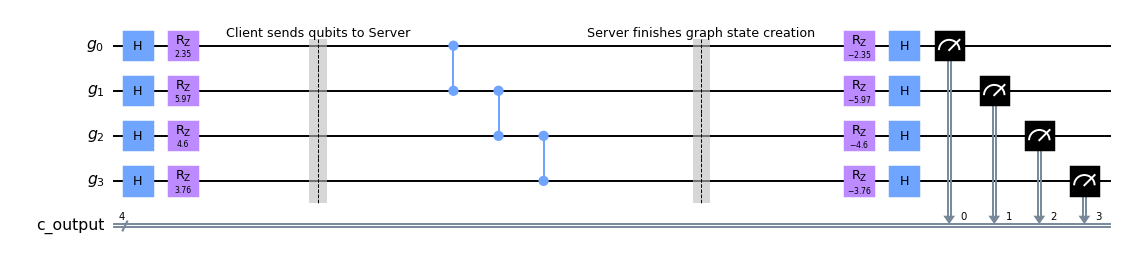

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer

# Define registers. Let's have 4 qubits for the graph state.
# Let's say: q0, q1 = computation, q2 = trap, q3 = dummy
graph_qubits = QuantumRegister(4, 'g')
# Classical registers to hold measurement results from the server
output_bits = ClassicalRegister(4, 'c_output')

# Create a circuit
qc = QuantumCircuit(graph_qubits, output_bits)

# --- CLIENT'S PREPARATION (A_i) ---
# This happens locally on the client's device before qubits are sent.
# The client chooses random angles θ for each qubit.
np.random.seed(42) # For reproducibility, but in reality this is random
theta = list(2 * np.pi * np.random.rand(4)) # Random angles between 0 and 2π

# The client applies the preparation rotation Rz(θ) to |+>
# This creates the state |+_θ> = Rz(θ)|+> = (|0> + e^{iθ}|1>)/√2
for i, angle in enumerate(theta):
    qc.h(graph_qubits[i])   # Prepare |+>
    qc.rz(angle, graph_qubits[i]) # Apply client's secret rotation Rz(θ)
    # Note: In a real protocol, these qubits would now be sent to the server.

qc.barrier(label='Client sends qubits to Server')

# --- SERVER'S ENTANGLEMENT (B_j) ---
# The server receives the 4 qubits and entangles them according to the graph structure.
# We choose a simple linear graph: 0-1-2-3
# Entangle qubit 0 and 1
qc.cz(graph_qubits[0], graph_qubits[1])
# Entangle qubit 1 and 2
qc.cz(graph_qubits[1], graph_qubits[2])
# Entangle qubit 2 and 3
qc.cz(graph_qubits[2], graph_qubits[3])

qc.barrier(label='Server finishes graph state creation')

# --- CLIENT'S MEASUREMENT INSTRUCTIONS ---
# The client calculates the measurement angle δ for each qubit based on:
# δ_j = φ'_j + θ_j + r_j * π
# Where φ'_j is a correction based on previous outcomes (not modeled here for simplicity),
# and r_j is a random bit to hide the result.

# For this demo, let's set all r_j = 0 and φ'_j = 0.
# So the server is instructed to measure in the basis defined by δ_j = θ_j.

# The server now measures all qubits.
for i, angle in enumerate(theta):
    # The server rotates the qubit back by -θ_i to "remove" the client's encryption...
    qc.rz(-angle, graph_qubits[i])
    # ...and then measures in the X-basis.
    qc.h(graph_qubits[i])
    qc.measure(graph_qubits[i], output_bits[i])

# Draw the circuit
qc.draw('mpl', style='clifford', scale=0.7, fold=-1)

####WITH VISUALIZATION

Client's secret θ angles: [2.35 5.97 4.6  3.76] radians

** Circuit Diagram **

--- ANALYSIS OF QUANTUM STATE EVOLUTION ---

** 1. After Client Preparation (Before Entanglement) **
The qubits are in a product state of |+_θ>, each with a unique phase.


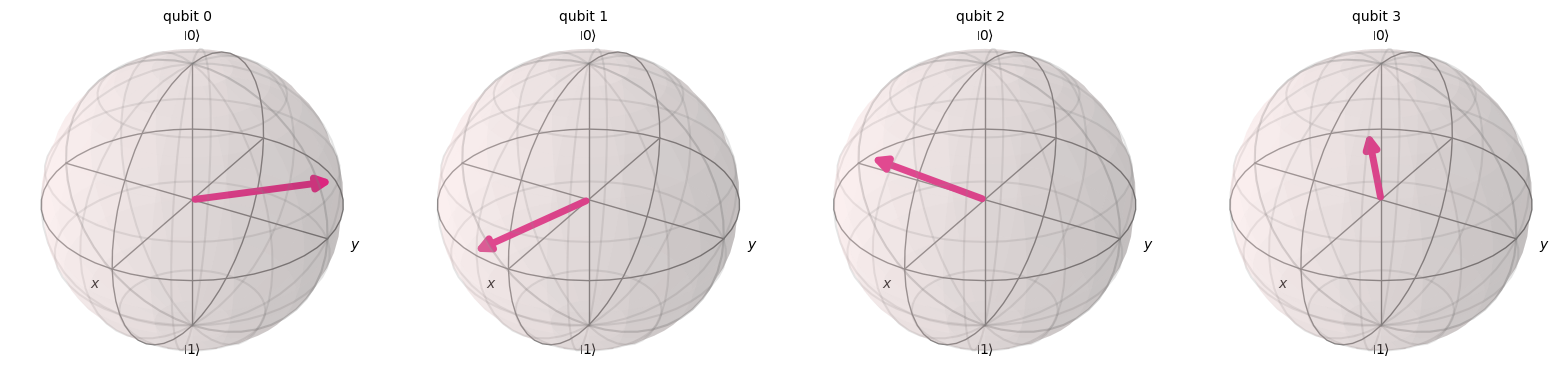


** 2. After Server Entanglement (Graph State) **
The qubits are now in a highly entangled graph state.

Density Matrix (Real and Imaginary Parts):


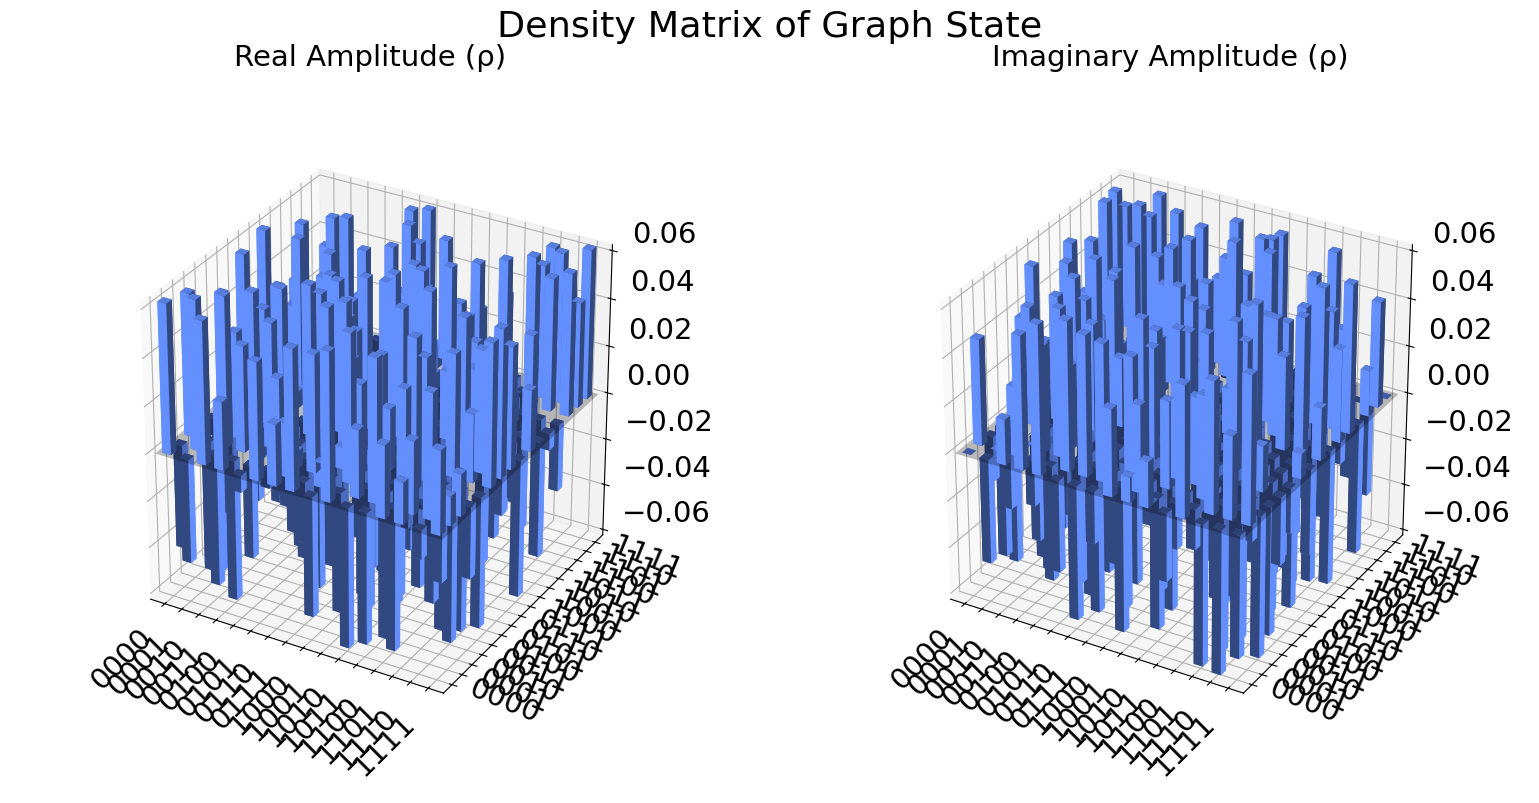

\nQ-Sphere Visualization (Global Phase & Entanglement):


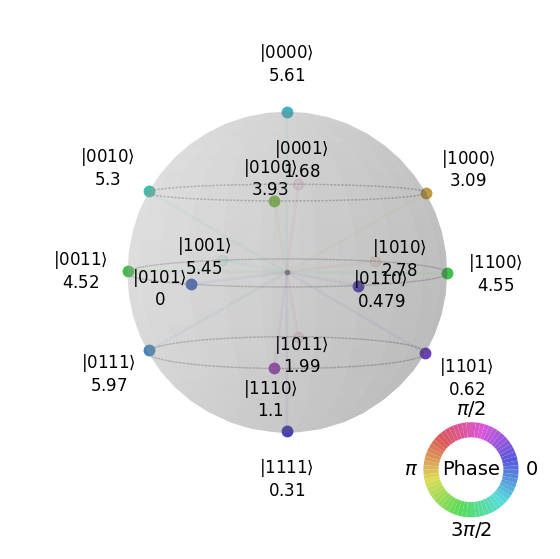


** 3. Before Measurement (After Server's Rotations) **
The server has 'unrotated' the qubits based on the client's instruction δ_j = θ_j.
The state should now be a simple |++++> state, ready for X-basis measurement.


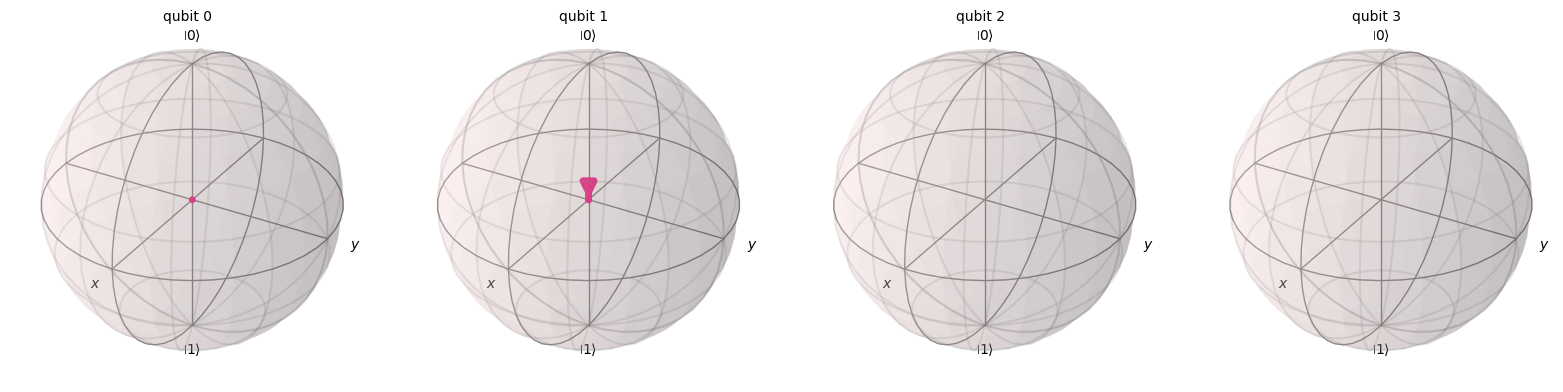


** 4. Final Measurement Results (Classical Bits) **
Since the state before measurement was |++++>, the measurement outcome should be 0000.
Actual measured result: {'1101': 1}


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector, plot_state_city, plot_state_qsphere

# 1. Define the circuit with save instructions
graph_qubits = QuantumRegister(4, 'g')
output_bits = ClassicalRegister(4, 'c_output')
qc = QuantumCircuit(graph_qubits, output_bits)

# Client's secret preparation angles (in radians)
np.random.seed(42)
theta = list(2 * np.pi * np.random.rand(4))
print(f"Client's secret θ angles: {np.round(theta, 2)} radians")

# Client prepares |+_θ> = Rz(θ)|+>
for i, angle in enumerate(theta):
    qc.h(graph_qubits[i])
    qc.rz(angle, graph_qubits[i])

# Save state after client preparation
qc.save_statevector(label='after_preparation')
qc.barrier(label=' | Client sends qubits to Server |')

# Server entangles them into a graph state (linear chain)
qc.cz(graph_qubits[0], graph_qubits[1])
qc.cz(graph_qubits[1], graph_qubits[2])
qc.cz(graph_qubits[2], graph_qubits[3])

# Save state after server entanglement
qc.save_statevector(label='after_entanglement')
qc.barrier(label=' | Server finishes graph state |')

# Server measures (as instructed by client: δ_j = θ_j for this demo)
for i, angle in enumerate(theta):
    qc.rz(-angle, graph_qubits[i]) # Server reverses client's rotation
    qc.h(graph_qubits[i])           # Measures in X-basis

# Save state before measurement (after rotations)
qc.save_statevector(label='before_measurement')
qc.measure(graph_qubits, output_bits)

# 2. Draw the circuit
print("\n** Circuit Diagram **")
qc.draw('mpl', style='clifford', scale=0.5, fold=-1)
plt.show()

# 3. Simulate using AerSimulator
simulator = AerSimulator(method='statevector')
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1)
result = job.result()

# 4. Extract and visualize the saved statevectors
print("\n--- ANALYSIS OF QUANTUM STATE EVOLUTION ---")

# Get the state after client preparation
state_after_prep = result.data(0)['after_preparation']
print("\n** 1. After Client Preparation (Before Entanglement) **")
print("The qubits are in a product state of |+_θ>, each with a unique phase.")
display(plot_bloch_multivector(state_after_prep))

# Get the state after server entanglement
state_after_entangle = result.data(0)['after_entanglement']
print("\n** 2. After Server Entanglement (Graph State) **")
print("The qubits are now in a highly entangled graph state.")
print("\nDensity Matrix (Real and Imaginary Parts):")
display(plot_state_city(state_after_entangle, title='Density Matrix of Graph State'))
print(r"\nQ-Sphere Visualization (Global Phase & Entanglement):")
display(plot_state_qsphere(state_after_entangle, show_state_phases=True))

# Get the state before measurement
state_before_measure = result.data(0)['before_measurement']
print("\n** 3. Before Measurement (After Server's Rotations) **")
print("The server has 'unrotated' the qubits based on the client's instruction δ_j = θ_j.")
print("The state should now be a simple |++++> state, ready for X-basis measurement.")
display(plot_bloch_multivector(state_before_measure))

# 5. Show the final measurement result (classical bits)
print("\n** 4. Final Measurement Results (Classical Bits) **")
print("Since the state before measurement was |++++>, the measurement outcome should be 0000.")
print("Actual measured result:", result.get_counts())

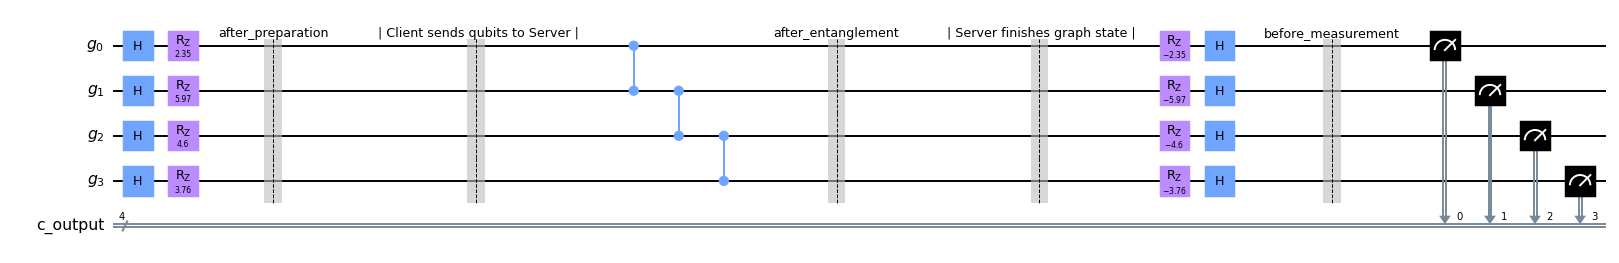

In [7]:
qc.draw('mpl', style='clifford', scale=0.7, fold=-1)